In [6]:
#======Core============
import pandas as pd
import numpy as np
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
#======PyForecast======
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

import warnings
warnings.filterwarnings('ignore')

In [24]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-15"
end_date = "2021-12-31"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-14.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-15.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-16.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-17.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-18.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-19.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-20.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-21.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-22.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-23.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-24.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-25.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-26.csv


In [25]:
df.head()

,open,high,low,close,volume,tic
2021-12-15 00:00:00,48336.95,48343.28,48328.21,48338.04,1.71661,BTCUSDT
2021-12-15 00:00:01,48338.05,48349.90,48338.04,48349.90,1.81497,BTCUSDT
2021-12-15 00:00:02,48349.89,48349.90,48340.70,48346.77,1.03211,BTCUSDT
2021-12-15 00:00:03,48343.28,48349.83,48340.70,48349.83,0.17148,BTCUSDT
2021-12-15 00:00:04,48346.77,48346.77,48339.75,48339.75,0.05336,BTCUSDT


In [26]:
df.reset_index(inplace=True)
df.rename(columns={'index':'time'}, inplace=True)
df['time_idx'] = df.index
df.drop(['open','high','low','volume', 'tic'], inplace=True, axis=1)

In [29]:
df['series'] = 0
df['time'] = pd.to_datetime(df['time'])

In [31]:
df.head()

,time,close,time_idx,series
0,2021-12-15 00:00:00,48338.04,0,0
1,2021-12-15 00:00:01,48349.90,1,0
2,2021-12-15 00:00:02,48346.77,2,0
3,2021-12-15 00:00:03,48349.83,3,0
4,2021-12-15 00:00:04,48339.75,4,0


In [76]:
#80% used for train-val, (where val is only the last future_window datapoints)
df_train_val = df[:int(0.8*len(df))]
df_test = df[int(0.8*len(df)):]

# Timeseries Dataset

In [81]:
# define dataset: lookback 30 intervals, predict 10 into future
max_encoder_length = 30
max_prediction_length = 10
#training_cutoff = df_train_val["time_idx"].max() - future_window
training_cutoff = df_train_val["time_idx"].max() - 70 # this allows 60 predictions (given max_prediction_length is 10?)
#said smt about at least back+forward lengths
training_cutoff

1174989

In [82]:
training = TimeSeriesDataSet(
    df_train_val[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df_train_val.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
)

In [83]:
validation = TimeSeriesDataSet.from_dataset(training, df_train_val, min_prediction_idx=training_cutoff + 1)
# ^ Generate dataset with different underlying data but same variable encoders and scalers, etc.
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [85]:
df_test

,time,close,time_idx,series
1175040,2021-12-28 14:24:00,49044.74,1175040,0
1175041,2021-12-28 14:24:01,49035.16,1175041,0
1175042,2021-12-28 14:24:02,49032.62,1175042,0
1175043,2021-12-28 14:24:03,49028.70,1175043,0
1175044,2021-12-28 14:24:04,49022.09,1175044,0
...,...,...,...,...
1468795,2021-12-31 23:59:55,46216.94,1468795,0
1468796,2021-12-31 23:59:56,46216.93,1468796,0
1468797,2021-12-31 23:59:57,46200.01,1468797,0
1468798,2021-12-31 23:59:58,46200.05,1468798,0


In [87]:
# testing dataset
testing = TimeSeriesDataSet(
    df_test,
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df_test.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
)

In [88]:
#testingTSDS = TimeSeriesDataSet.from_dataset(testing, df_train_val, min_prediction_idx=training_cutoff + 1)
batch_size = 128
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
# train=False allows it to do the prediction over all values...or smt
# see here: https://github.com/jdb78/pytorch-forecasting/issues/446

# Train Network
using `generic` parameters

In [89]:
# Params
lr = 3e-2
weight_decay=1e-2
widths=[32, 512]
backcast_loss_ratio=0.1

In [90]:
pl.seed_everything(42, workers=True)

trainer = pl.Trainer(devices="auto", accelerator="auto", gradient_clip_val=0.01) #clipping gradient to prevent explosion
net = NBeats.from_dataset(training, learning_rate=lr, weight_decay=weight_decay, widths=widths, backcast_loss_ratio=backcast_loss_ratio)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Global seed set to 42
Finding best initial lr: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 20.78it/s]


suggested learning rate: 0.7079457843841377


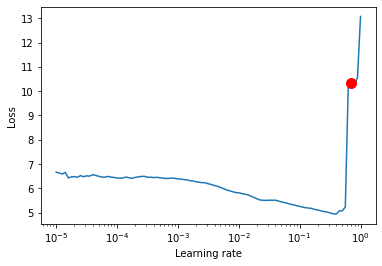

In [91]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
#use suggested optimal lr
net.hparams.learning_rate = res.suggestion()

# Fitting Model

In [92]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.594     Total estimated model params size (MB)


Global seed set to 42


Epoch 0: 100%|█████████████████| 31/31 [00:01<00:00, 16.99it/s, loss=5, v_num=2, train_loss_step=4.490]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█| 31/31 [00:01<00:00, 15.97it/s, loss=5, v_num=2, train_loss_step=4.490, val_loss=4.310]
Epoch 1:  97%|▉| 30/31 [00:01<00:00, 16.42it/s, loss=3.85, v_num=2, train_loss_step=3.200, val_loss=4.3
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:01<00:00, 15.91it/s, loss=3.85, v_num=2, train_loss_step=3.200, val_loss=4.2
Epoch 2:  97%|▉| 30/31 [00:01<00:00, 16.43it/s, loss=3.52, v_num=2, train_loss_step=3.500, val_loss=4.2
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:01<00:00, 15.92it/s, loss=3.52, v_num=2, train_loss_step=3.500, val_loss=3.9
Epoch 3:  97%|▉| 30/31 [00:01<00:00, 16.30it/s, loss=3.41, v_num=2, train_l

# Evaluate Results

In [93]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [94]:
# Predicting on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(11.1630)

In [95]:
# look at random samples in validation set prediction
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [107]:
len(x), len(raw_predictions)

(11, 5)

In [ ]:
# this encoder decoder length thing is confusing me... but yeah 41 is magic number for len(val_set)==50

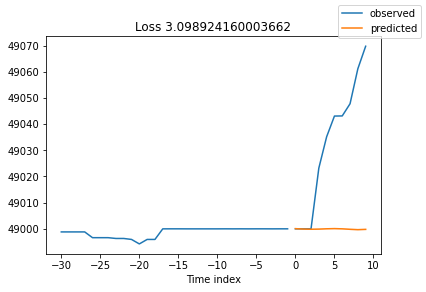

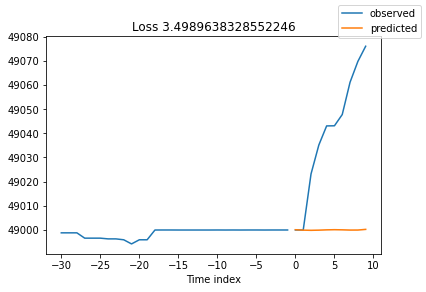

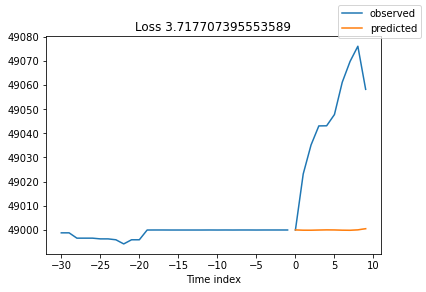

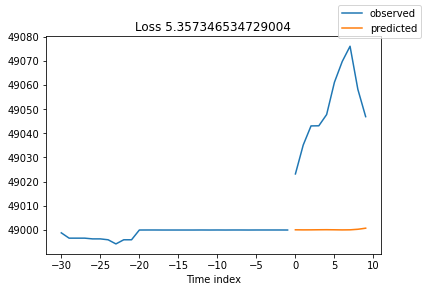

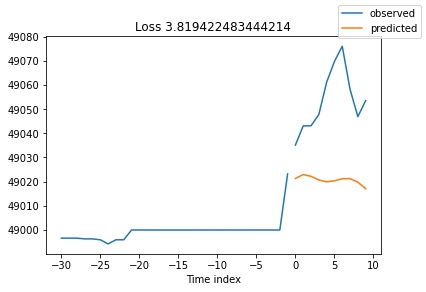

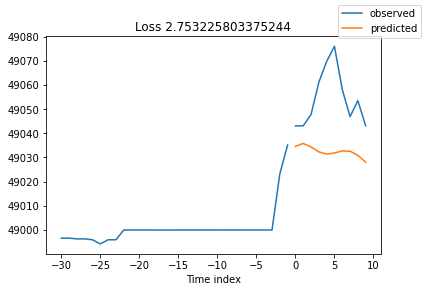

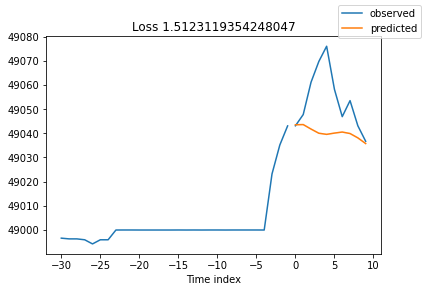

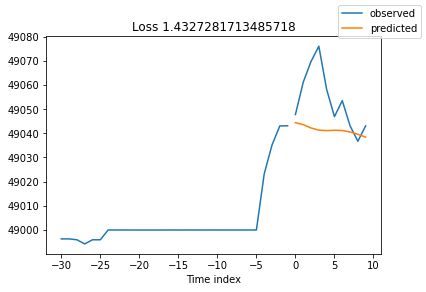

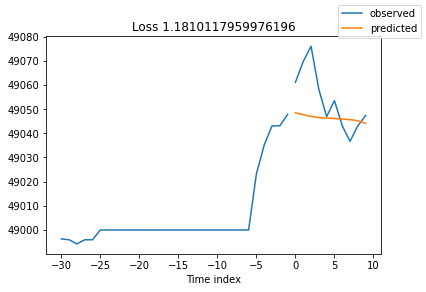

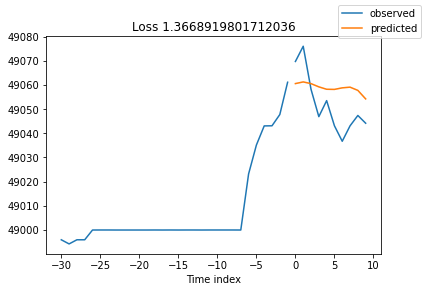

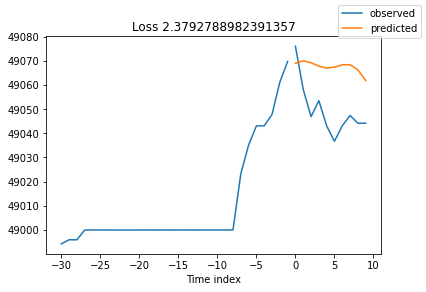

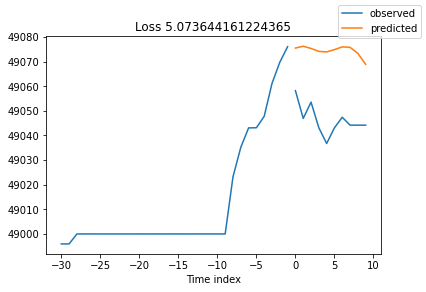

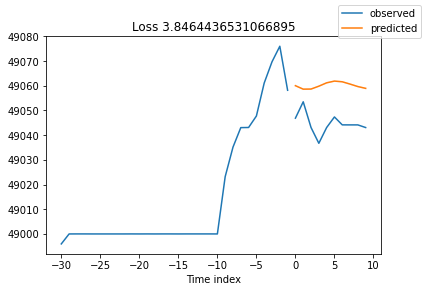

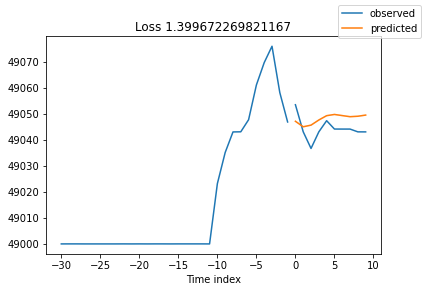

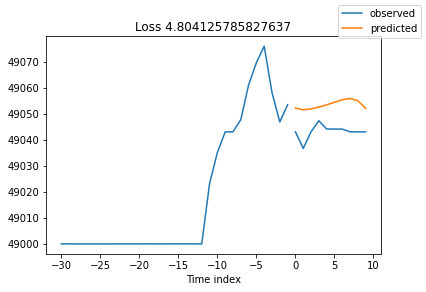

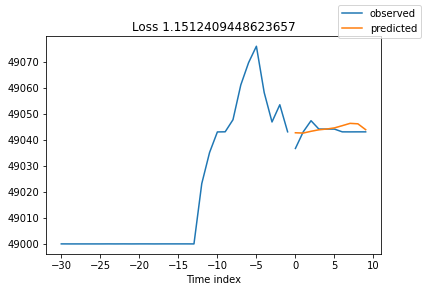

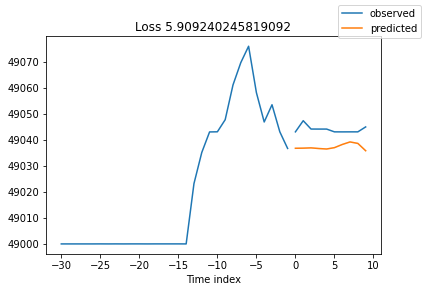

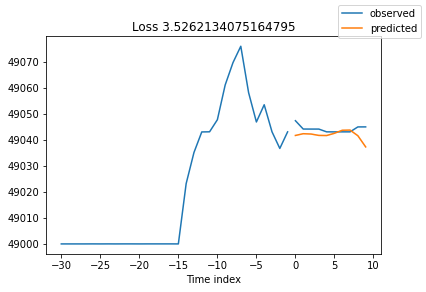

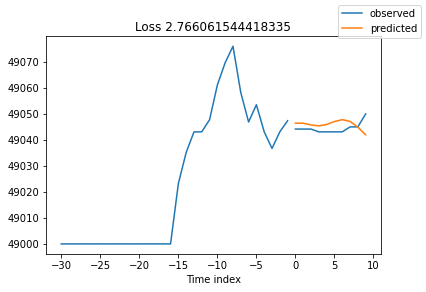

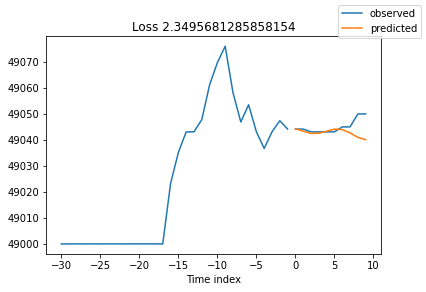

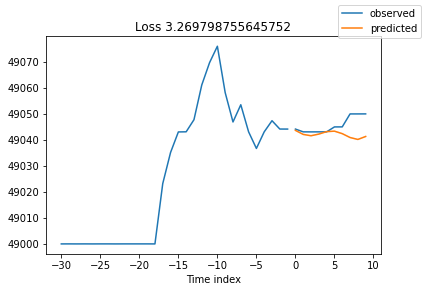

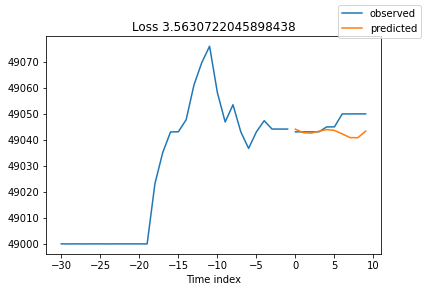

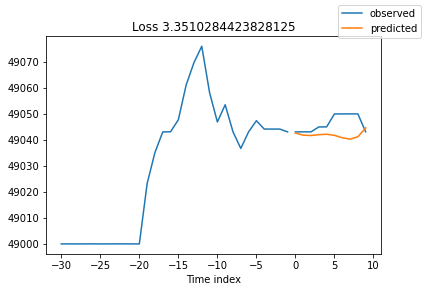

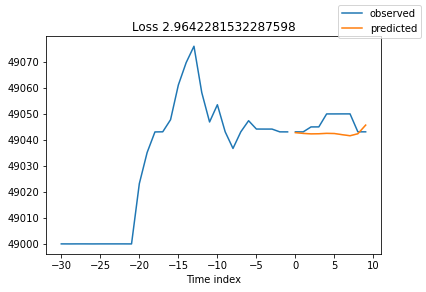

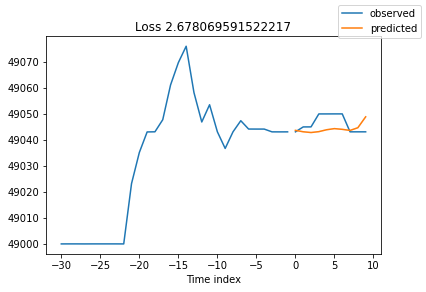

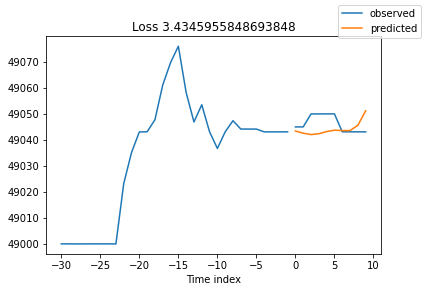

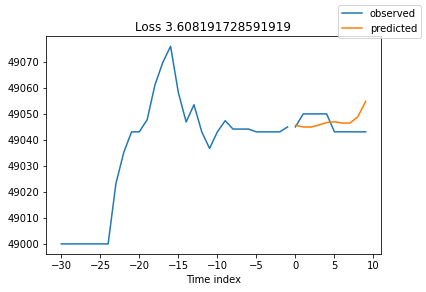

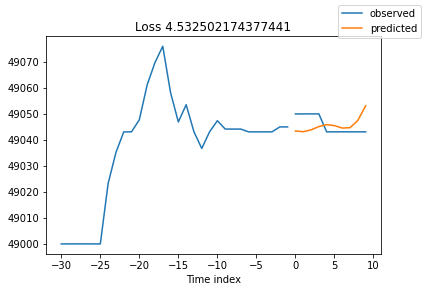

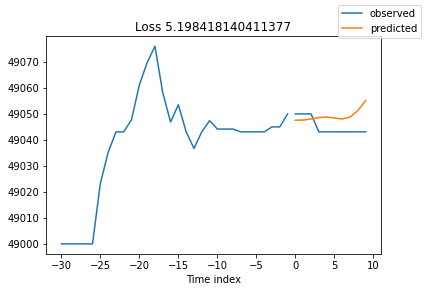

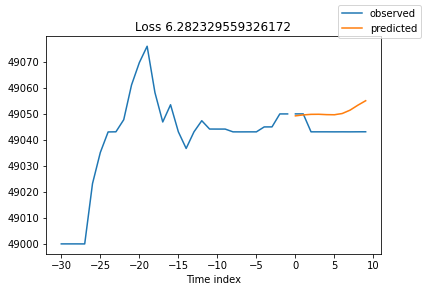

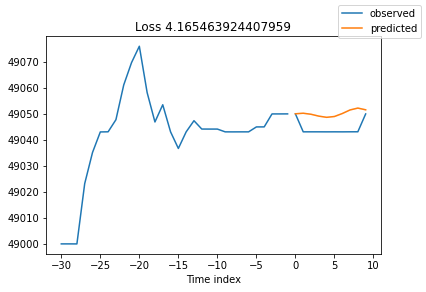

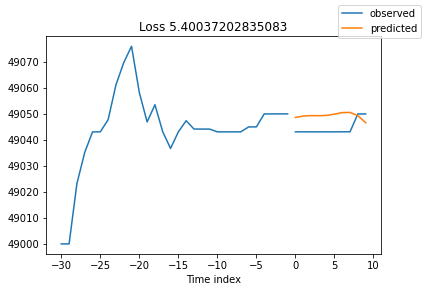

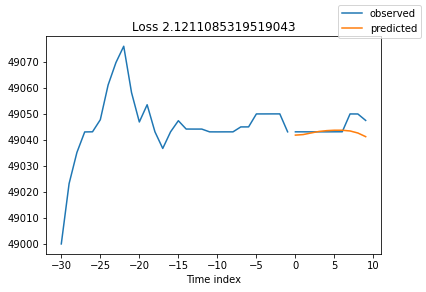

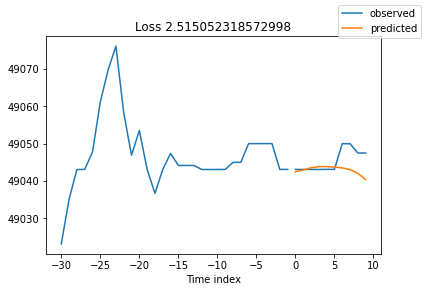

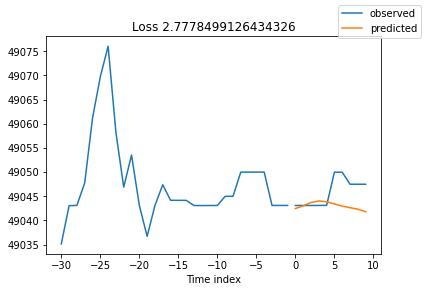

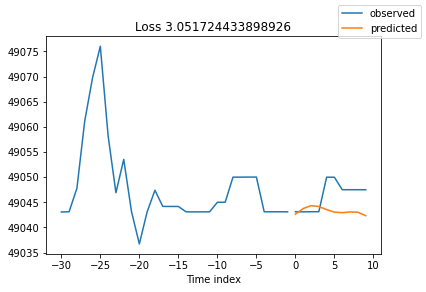

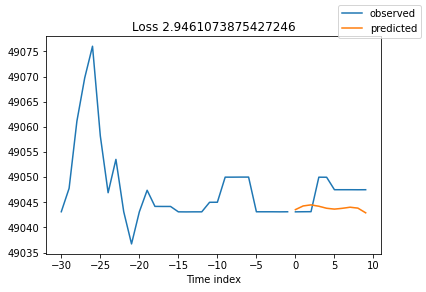

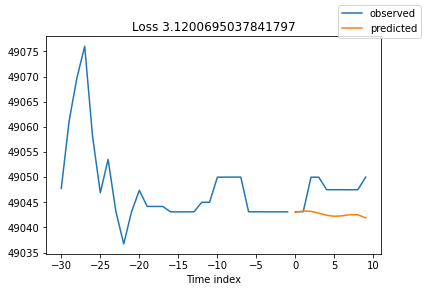

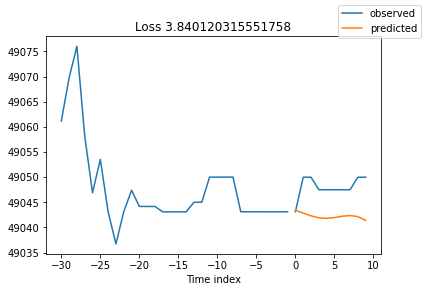

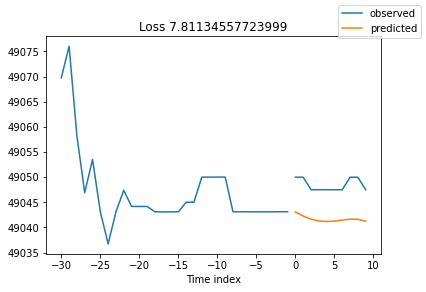

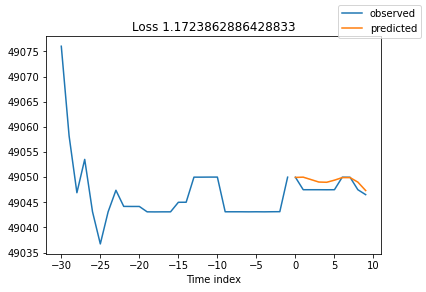

In [119]:
for idx in range(41):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Predict on testing dataset